The data comes from https://firstratedata.com/, but their free samples seem to be tied to the day you request to have them.

I tried to find stocks in different fields.

I didn't feel the need to test for trends because my window is so short (just a couple of weeks)

I chose to use GRU based on this paper: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9141105/#:~:text=2.4.-,Recurrent%20Neural%20Networks%20(RNNs),time%20intervals%20or%20time%20steps. Long Term Short Term networks may also work but they may be time intensive. "GRUs are simplified version of LSTMs that use single “update gate” to control the flow of information into the memory cell. GRUs are easier to train and faster to run than LSTMs, but they may not be as effective at storing and accessing long-term dependencies."

I have access to 10 days worth of minute-to-minute data, for 7 stocks in different fields. I used a "walk forward" stratedy to train my models: giving it two and a half days worth of data (from 8am day 1 to 11:59am on day 3) and then asked it to predict the price at noon, 2pm, and the closing price at 4pm on day 3. Once the model was tuned, I had it work from day 1 into the middle of day 4, and so on until the final day's worth of data was reached (the test set).

In [273]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler

from datetime import datetime as dt

from keras.models import Sequential
from keras.layers import *
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.layers import GRU
from keras.callbacks import ModelCheckpoint

import tensorflow

In [274]:
df_aal = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/AAL_1min_sample.csv")
df_fdx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FDX_1min_sample.csv")
df_fis = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/FIS_1min_sample.csv")
df_mcy = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/M_1min_sample.csv")
df_spr = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/S_1min_sample.csv")
df_sbx = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/SBUX_1min_sample.csv")
df_tsl = pd.read_csv("https://raw.githubusercontent.com/FerdinandBeaman/Capstone/main/1MinSamples/TSLA_1min_sample.csv")

all_dfs = [df_aal, df_fdx, df_fis, df_mcy, df_sbx, df_spr, df_tsl]

In [275]:
for df in all_dfs:
    print(len(df))

5700
4231
4396
5595
4776
5050
10005


In [276]:
for df in all_dfs:
    df['timestamp'] = pd.to_datetime(df['timestamp'])

In [277]:
# for df in all_dfs:
#     print(df.isnull().sum())
#     print("\n")

Next, I am just looking for the latest time that any of my stocks began to track their prices and the earliest time that any of them stopped tracking their prices. This way, I can make all of my data uniform in length.

In [278]:
for df in all_dfs:
    print(df["timestamp"][0])

2024-02-26 04:03:00
2024-02-26 06:09:00
2024-02-26 06:06:00
2024-02-26 04:41:00
2024-02-26 08:00:00
2024-02-26 04:00:00
2024-02-26 04:00:00


In [279]:
for df in all_dfs:
    print(df["timestamp"].iloc[-1])

2024-03-11 19:44:00
2024-03-11 18:11:00
2024-03-11 16:00:00
2024-03-11 19:39:00
2024-03-11 19:04:00
2024-03-11 19:38:00
2024-03-11 19:54:00


So 8am on the 26th and 4pm on the 11th.

In [280]:
for df in all_dfs:
    df.set_index('timestamp', inplace=True)

In [281]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df.resample("1min").asfreq().ffill()

In [282]:
for i, df in enumerate(all_dfs):
    all_dfs[i] = df['2024-02-26 08:00' : "2024-03-11 16:00" ]

In [283]:
for i, df in enumerate(all_dfs):
    all_dfs[i].drop(["high", "low", "close"], axis = 1, inplace = True)

In [284]:
seven_dfs = pd.concat(all_dfs, axis=1)

In [285]:
cols = ["open_1", "volume_1", "open_2", "volume_2", "open_3",
                   "volume_3", "open_4", "volume_4", "open_5", "volume_5",
                   "open_6", "volume_6", "open_7", "volume_7"]

seven_dfs.set_axis(column_names, axis = 1, inplace = True)

<ipython-input-285-665019512337>:5: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  seven_dfs.set_axis(column_names, axis = 1, inplace = True)


In [286]:
# Getting the first one and a half days of data for the initial training set,
# Then using that to scale all of my data.


train_36_hrs = seven_dfs['2024-02-26 08:00' : "2024-02-28 12:00" ]

scaler = StandardScaler()

train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])
seven_dfs[cols] = scaler.transform(seven_dfs[cols])

<ipython-input-286-5950431c8b46>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_36_hrs[cols] = scaler.fit(train_36_hrs[cols])


In [287]:
seven_dfs.index[0].dayofweek

0

In [288]:
seven_dfs["hour"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["hour"][i] = seven_dfs.index[i].hour

seven_dfs["day"] = np.nan
for i in range(len(seven_dfs)):
  seven_dfs["day"][i] = seven_dfs.index[i].dayofweek

In [289]:
seven_dfs.drop(seven_dfs[(seven_dfs["hour"] < 8) |
                        (seven_dfs["hour"] > 15)].index, inplace = True)
seven_dfs.drop(seven_dfs[seven_dfs["day"] > 4].index, inplace = True)

In [290]:
len(seven_dfs)

5280

<Axes: xlabel='timestamp'>

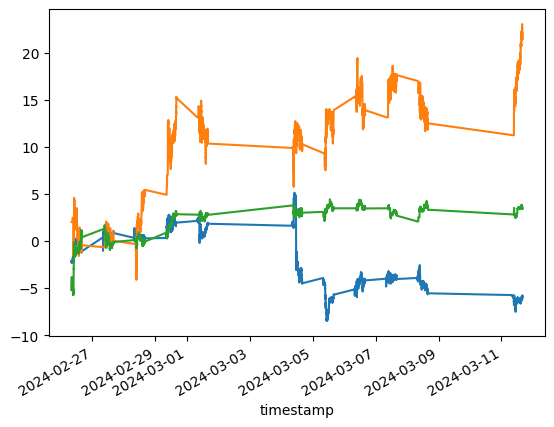

In [291]:
seven_dfs.open_1.plot()
seven_dfs.open_2.plot()
seven_dfs.open_3.plot()

<Axes: xlabel='timestamp'>

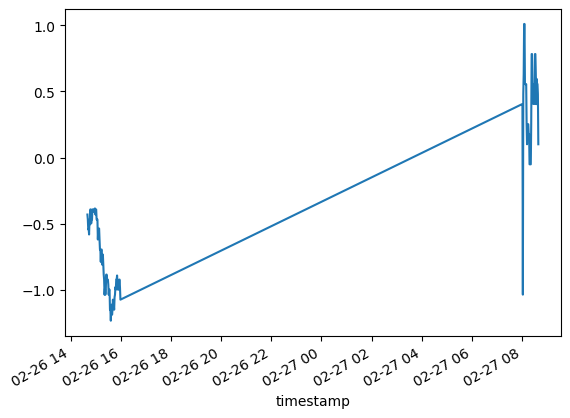

In [292]:
seven_dfs["open_1"][400:520].plot()

In [293]:
seven_dfs.head()

,open_1,volume_1,open_2,volume_2,open_3,volume_3,open_4,volume_4,open_5,volume_5,open_6,volume_6,open_7,volume_7,hour,day
timestamp,,,,,,,,,,,,,,,,
2024-02-26 08:00:00,-2.100848,-0.093564,2.016769,-0.532078,-5.221488,-0.228318,-0.228851,-0.215751,3.020294,-0.138828,-3.257354,0.024639,-3.811763,0.080885,8.0,0.0
2024-02-26 08:01:00,-2.100848,-0.093564,2.016769,-0.532078,-5.221488,-0.228318,-0.228851,-0.215751,3.020294,-0.138828,-3.991742,-0.164978,-4.343619,-0.503601,8.0,0.0
2024-02-26 08:02:00,-2.100848,-0.093564,2.016769,-0.532078,-5.221488,-0.228318,-0.228851,-0.215751,3.020294,-0.138828,-3.514390,-0.177344,-3.912113,-0.476202,8.0,0.0
2024-02-26 08:03:00,-2.100848,-0.093564,2.016769,-0.532078,-5.221488,-0.228318,-0.228851,-0.215751,3.020294,-0.138828,-3.514390,-0.177344,-4.343619,-0.486180,8.0,0.0
2024-02-26 08:04:00,-2.325211,-0.214596,2.016769,-0.532078,-3.818034,-0.248721,-0.228851,-0.215751,2.531568,-0.133707,-3.587829,-0.181466,-3.972323,-0.458725,8.0,0.0


In [3]:
# Code repurposed from Greg Hogg: https://www.youtube.com/watch?v=c0k-YLQGKjY
def df_to_Xy(df, window):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df)-window):
    X.append([[a] for a in df_as_np[i:i+window]])
    y.append(df_as_np[i+window])
  return np.array(X), np.array(y)

In [ ]:
X, y = df_to_Xy

In [44]:
model_1 = Sequential()
model_1.add(InputLayer(3120, 14))
model_1.add(GRU(7))

In [ ]:
# Code repurposed from Greg Hogg: https://www.youtube.com/watch?v=kGdbPnMCdOg


def plot_pred(model, X, y, start=0, end=3601):
  preds = model.predict(X).flatten()
  df = pd.DataFrame(data{"Predictions":preds, "Actuals":y})
  plt.plot(df["Predictions"][start:end])
  plt.plot(df["Actuals"][start:end])
  return df, mse(y, preds)